In [237]:
import pandas as pd
import numpy as np
import seaborn as sns

In [238]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, TransformerMixin

In [239]:
from sklearn.model_selection import train_test_split

In [240]:
df = pd.read_csv('../data_exploration/housing.csv')

In [241]:
df

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY
...,...,...,...,...,...,...,...,...,...,...
20635,-121.09,39.48,25.0,1665.0,374.0,845.0,330.0,1.5603,78100.0,INLAND
20636,-121.21,39.49,18.0,697.0,150.0,356.0,114.0,2.5568,77100.0,INLAND
20637,-121.22,39.43,17.0,2254.0,485.0,1007.0,433.0,1.7000,92300.0,INLAND
20638,-121.32,39.43,18.0,1860.0,409.0,741.0,349.0,1.8672,84700.0,INLAND


/var/folders/jq/v410fr9n359bq2pnqqynmpy40000gp/T/ipykernel_68880/328259710.py:2: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.tril(np.ones_like(df2.corr(), dtype=np.bool))


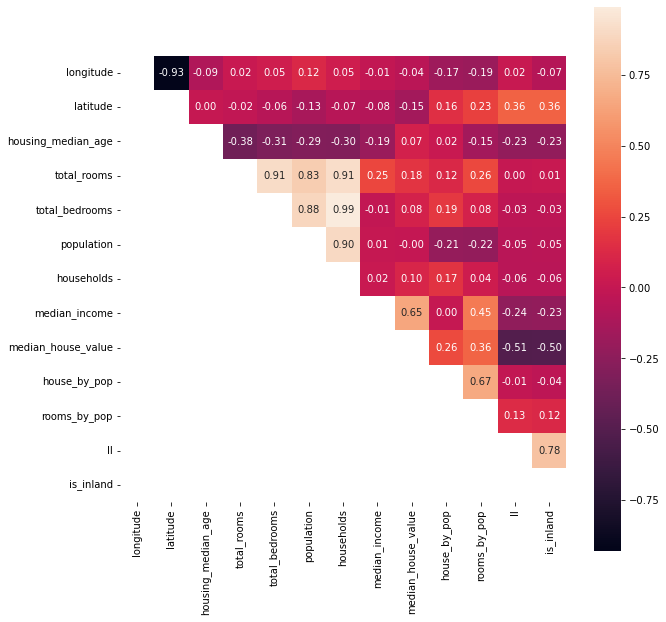

In [242]:
f = plt.figure(figsize=(10,10))
mask = np.tril(np.ones_like(df2.corr(), dtype=np.bool))
sns.heatmap(df2.corr(), annot=True, fmt=".2f", mask = mask, square = True)
plt.show;

Preprocessing with pipelines

In [243]:
class New_features(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        df['house_by_pop'] = df["households"]/df["population"]
        df['rooms_by_pop'] = df["total_rooms"]/df["population"]
        df2['rooms_by_houses'] = df["total_rooms"]/df["households"]
        # Combining longitude and latitude
        df['ll'] = df['longitude'] + df['latitude']
        df['is_inland'] = 1*(df['ocean_proximity']=='INLAND')
        
        df.drop(columns=[#'longitude','latitude',
                         'households','population','total_bedrooms'], inplace=True)
        return df.drop(columns='ocean_proximity')

In [244]:
class Drop_target(BaseEstimator, TransformerMixin):
    def fit(self, X, y=None):
        return self
    
    def transform(self, df):
        return df[df['median_house_value'] != df['median_house_value'].max()]

In [245]:
class Drop_outliers(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        self.df = df
        std7 = df.max() - (7*df.std() + df.quantile(q=0.75)) 
        self.index = std7[std7>0].index
        
        self.max_threshold = {}
        for i in self.index:
            self.max_threshold[i] = df[i].quantile(0.99)
        # I scaled my data beforehand
        return self

    def transform(self, df):
        for i in self.index:
            df = df[df[i]<self.max_threshold[i]]
        return df

In [246]:
class Drop_features(BaseEstimator, TransformerMixin):
    def fit(self, df, y=None):
        self.df = df
        std7 = df.max() - (7*df.std() + df.quantile(q=0.75)) 
        self.index = std7[std7>0].index
        
        self.max_threshold = {}
        for i in self.index:
            self.max_threshold[i] = df[i].quantile(0.99)
        # I scaled my data beforehand
        return self

    def transform(self, df):
        for i in self.index:
            df = df[df[i]<self.max_threshold[i]]
        return df

In [247]:
pipeline_df = Pipeline(steps=[
    ('new_features', New_features()),
    ('drop_outliers', Drop_outliers()),
    ('drop_rows', Drop_target())
])

In [248]:
df2 = pipeline_df.fit_transform(df)

In [249]:
#df2.drop(columns=['longitude','total_bedrooms','households','population'],inplace=True)

In [250]:
df.shape, df2.shape, df2.shape[0]/df.shape[0]

((20640, 11), (19122, 10), 0.9264534883720931)

In [251]:
#df = df[df['total_rooms']<11333]
target = 'median_house_value'
y = df2[target]
X = df2.drop(columns=target)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=0)

In [252]:
class My_hot_encoding(BaseEstimator, TransformerMixin):
    def fit(self, df, y):
        self.df = df
        self.y = y
        return self
    
    def transform(self, df):
        dummies = pd.get_dummies(df['ocean_proximity'], drop_first=True)
        df2 = pd.concat([df,dummies],axis='columns')
        index_to_remove = (dummies.mean() < 0.05)[dummies.mean() < 0.05].index
        
        return df2.drop(columns=np.append(np.array(index_to_remove).flatten(),'ocean_proximity'))

In [253]:
categorical_cols = X_train.select_dtypes(exclude=np.number).columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', min_frequency = 0.05))
])

In [254]:
numerical_cols = X_train.select_dtypes(include=np.number).columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [255]:
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

In [256]:
pp_X_train = preprocessor.fit_transform(X_train)
pp_X_test = preprocessor.transform(X_test)

### Modeling

In [257]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import cross_val_score

In [258]:
cross_val_score(DecisionTreeRegressor(), pp_X_train, y_train).mean()

0.6132636421098028

In [259]:
cross_val_score(RandomForestRegressor(), pp_X_train, y_train).mean()

0.8127266543299327

In [260]:
cross_val_score(LinearRegression(), pp_X_train, y_train).mean()

0.647724990267967

In [261]:
mod_rf = RandomForestRegressor(n_estimators= 100)
mod_dt = DecisionTreeRegressor(max_depth=7)
mod_lr = LinearRegression()

In [262]:
mod_rf.fit(pp_X_train,y_train)
mod_dt.fit(pp_X_train,y_train)
mod_lr.fit(pp_X_train,y_train)

LinearRegression()

In [263]:
print(mod_rf.score(pp_X_test,y_test))
print(mod_dt.score(pp_X_test,y_test))
print(mod_lr.score(pp_X_test,y_test))

0.8094997174278561
0.688354523715774
0.6387806846805031


<BarContainer object of 9 artists>

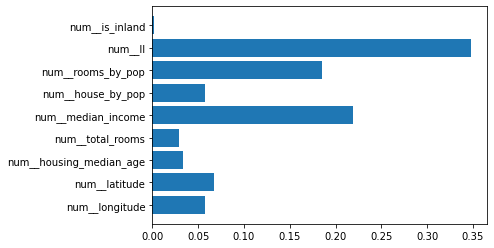

In [264]:
plt.barh(preprocessor.get_feature_names_out(), mod_rf.feature_importances_)

In [124]:
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

In [125]:
# Tuning Random Forest Regressor
scores_train = []
scores_test = []
estimators = np.arange(10,100,10)

for e in estimators:
    model = RandomForestRegressor(n_estimators = e)
    model.fit(pp_X_train,y_train)
    y_train_pred = model.predict(pp_X_train)
    y_test_pred = model.predict(pp_X_test)
    scores_train.append(mean_absolute_error(y_train, y_train_pred))
    scores_test.append(mean_absolute_error(y_test, y_test_pred))

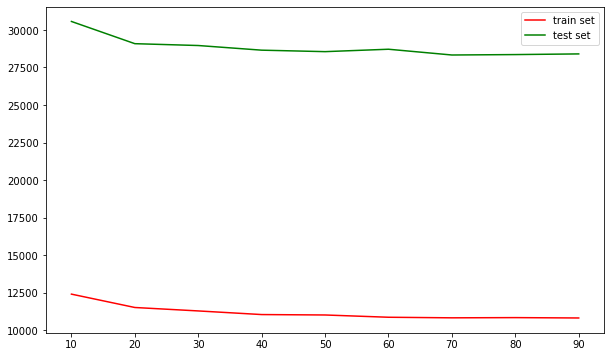

In [126]:
plt.figure(figsize=(10,6))
plt.plot(estimators,scores_train,color='r', label='train set')
plt.plot(estimators,scores_test,color='g', label='test set')
plt.legend()

In [23]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [24]:
model_params = {
    'RandomForestRegressor': {
        'model': RandomForestRegressor(),
        'params': {
            'n_estimators': [10,100,200],
        }
    },
     'DecisionTreeRegressor': {
         'model': DecisionTreeRegressor(),
         'params': {
             'max_depth': [5,7,10,20,50,100,150]
         }
     },
     'LinearRegression': {
         'model': LinearRegression(),
         'params': {}
     }
 
}

In [25]:
%%time

scores = []

for model_name, mp in model_params.items():
    mod =  GridSearchCV(mp['model'], mp['params'], cv=5)
    mod.fit(pp_X_train, y_train)
    scores.append({
        'model': model_name,
        'best_score': mod.best_score_,
        'best_params': mod.best_params_
    })
df = pd.DataFrame(scores,columns=['model','best_score','best_params'])
df

CPU times: user 1min 37s, sys: 687 ms, total: 1min 38s
Wall time: 1min 37s


,model,best_score,best_params
0,RandomForestRegressor,0.784272,{'n_estimators': 200}
1,DecisionTreeRegressor,0.657030,{'max_depth': 10}
2,LinearRegression,0.619741,{}
